In [382]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
    
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense

import tensorflow_probability as tfp
from scipy.stats import beta, truncnorm, gamma, poisson
from scipy.special import softmax

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20}) # set plot font sizes

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [383]:
def sample_pi(lambda_loc, lambda_scale, nu_loc, nu_scale, lambda_low=0, lambda_high=20, nu_low=0, nu_high=20,
             samples=10000, num_days=20):
    lambda_a = (lambda_low - lambda_loc) / lambda_scale
    lambda_b = (lambda_high-lambda_loc) /lambda_scale
    nu_a = (nu_low - nu_loc) / nu_scale
    nu_b = (nu_high-nu_loc) /nu_scale
    
    lambdas = truncnorm.rvs(lambda_a, lambda_b,
                            loc=lambda_loc, scale=lambda_scale,
                            size=samples)
    nus = truncnorm.rvs(nu_a, nu_b,
                        loc=nu_loc, scale=nu_scale,
                        size=samples)
    
    # days x samples
    poisson_prob =  np.stack([poisson.logpmf(day, lambdas) for day in range(1, num_days+1)])
    
    raw_pis = poisson_prob/nus

    assert np.isclose(poisson_prob[10,10]/nus[10], raw_pis[10,10])
    
    avg_raw_pi = np.mean(raw_pis, axis=1)
    
    pi = softmax(avg_raw_pi)

    
    return pi
    

In [460]:
# Infected -> Symptomatic in CovidEstim = Gamma(3.41, 0.61)
# Asymptomatic -> Mild in ours = lambda ~ N(4.7, 1), Nu ~ N(3.1, 1.2)

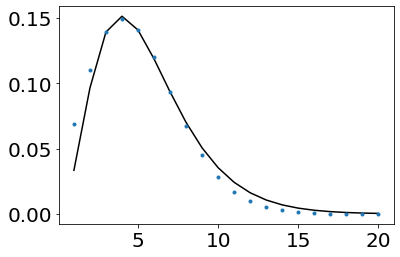

In [461]:
lambda_loc_param=4.7
lambda_scale_param=1
nu_loc_param=3.1
nu_scale_param=1.2

pi = sample_pi(lambda_loc_param, lambda_scale_param, nu_loc_param, nu_scale_param,samples=10000000)

x = range(1,20+1)
pdf_vals = gamma.pdf(x, a=3.41,loc=0, scale =1/0.61)
plt.plot(x, pdf_vals,
       'k-', label='gamma prior');
plt.plot(x,pi, '.', label='sampled poisson(lambda)/nu prior' )

In [530]:
# Symptomatic -> Severe in CovidEstim = Gamma(1.72, 0.22) 
# Mild -> Extreme in ours = lambda ~ N(4, 0.5), Nu ~ N(18, 8.1)

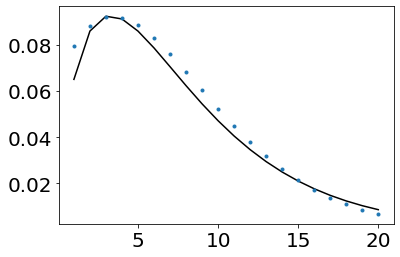

In [529]:
lambda_loc_param=4
lambda_scale_param=0.5
nu_loc_param=18
nu_scale_param=8.1

pi = sample_pi(lambda_loc_param, lambda_scale_param, nu_loc_param, nu_scale_param,samples=100000)

x = range(1,20+1)
pdf_vals = gamma.pdf(x, a=1.72,loc=0, scale =1/0.22)
plt.plot(x, pdf_vals,
       'k-', label='gamma prior');
plt.plot(x,pi, '.', label='sampled poisson(lambda)/nu prior' )

In [559]:
# Severe -> Death in Gamma(2.10, 0.23)
# Extreme -> Hospital in ours = lambda ~ N(3.3, 1), Nu ~ N(9, 0.2ttwtt

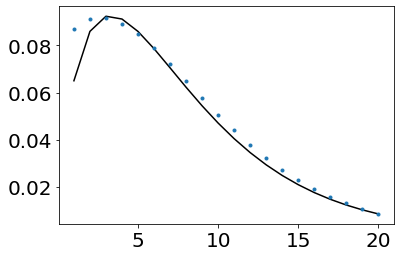

In [560]:
lambda_loc_param=3.3
lambda_scale_param=1
nu_loc_param=9
nu_scale_param=0.2

pi = sample_pi(lambda_loc_param, lambda_scale_param, nu_loc_param, nu_scale_param,samples=100000)

x = range(1,20+1)
pdf_vals = gamma.pdf(x, a=1.72,loc=0, scale =1/0.22)
plt.plot(x, pdf_vals,
       'k-', label='gamma prior');
plt.plot(x,pi, '.', label='sampled poisson(lambda)/nu prior' )

In [291]:
class LambdaNuModel(tf.keras.Model):
    
    def __init__(self,init_lambda_loc, 
                 init_lambda_scale,
                 init_nu_loc,
                 init_nu_scale, num_days=20,
                 samples=100000,
                 ):
        super(LambdaNuModel, self).__init__()
        self.num_days=num_days
        self.samples=100000
        
        self.unc_lambda_loc = tf.Variable(init_lambda_loc, dtype=tf.float32,
                                      name='lambda_loc', trainable=True)
        self.unc_lambda_scale = tf.Variable(init_lambda_scale, dtype=tf.float32,
                                        name='lambda_scale', trainable=True)
        self.unc_nu_loc = tf.Variable(init_nu_loc, dtype=tf.float32,
                                  name='nu_loc', trainable=True)
        self.unc_nu_scale = tf.Variable(init_nu_scale, dtype=tf.float32,
                                    name='nu_scale', trainable=True)
        
    def call(self, inputs):
        
        self.lambda_loc = tf.math.softplus(self.unc_lambda_loc)
        self.nu_loc = tf.math.softplus(self.unc_nu_loc)
        self.lambda_scale = tf.math.softplus(self.unc_lambda_scale)
        self.nu_scale = tf.math.softplus(self.unc_nu_scale)
        
        lambda_samples = tfp.distributions.TruncatedNormal(self.lambda_loc, self.lambda_scale,
                                                           0, self.num_days).sample((self.samples))
        nu_samples = tfp.distributions.TruncatedNormal(self.nu_loc, self.nu_scale,
                                                       0, self.num_days).sample((self.samples))
        
        pi = tf.TensorArray(tf.float32, size=self.num_days, clear_after_read=False,
                           name='pi')
        
        for day in range(self.num_days):
            
            log_pmf_samples = tfp.distributions.Poisson(rate=lambda_samples).log_prob(day+1)
            
            scaled_samples = log_pmf_samples/nu_samples
            
            pi = pi.write(day, tf.reduce_mean(scaled_samples))
            

            
        return tf.math.softmax(pi.stack())
        
        
        
        

In [365]:
class MaxAbsError(tf.keras.losses.Loss):

    def call(self, y_true, y_pred):

        return tf.math.reduce_max(tf.math.abs(y_pred - y_true))

In [476]:
lambda_loc_param=4.7
lambda_scale_param=1
nu_loc_param=1.7
nu_scale_param=0.1


model = LambdaNuModel(lambda_loc_param, lambda_scale_param, nu_loc_param, nu_scale_param, samples=10)

learning_rate =0.5

optimizer = tf.keras.optimizers.SGD(
    learning_rate=learning_rate, #momentum=0.98, nesterov=False, name='SGD'
)
loss = MaxAbsError()

model.compile(optimizer=optimizer, loss=loss)

day_array = np.arange(1,21,dtype=np.float32)
model.fit(x=[day_array],
         y=[gamma.pdf(day_array, a=3.41,loc=0, scale =1/0.61)],
         epochs=500)

Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 0.1763
Epoch 2/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1491
Epoch 3/500
1/1 [==============================] - 0s 7ms/step - loss: 0.1491
Epoch 4/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1491
Epoch 5/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1491
Epoch 6/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1491
Epoch 7/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1491
Epoch 8/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1491
Epoch 9/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1491
Epoch 10/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1491
Epoch 11/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1491
Epoch 12/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1490
Epoch 13/500
1/1 [==============================] - 0s 5ms/ste

1/1 [==============================] - 0s 5ms/step - loss: 0.1481
Epoch 207/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1482
Epoch 208/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1481
Epoch 209/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1481
Epoch 210/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1481
Epoch 211/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1481
Epoch 212/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1481
Epoch 213/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1481
Epoch 214/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1481
Epoch 215/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1481
Epoch 216/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1481
Epoch 217/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1481
Epoch 218/500
1/1 [==============================] - 0

1/1 [==============================] - 0s 5ms/step - loss: 0.1468
Epoch 411/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1468
Epoch 412/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1468
Epoch 413/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1468
Epoch 414/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1468
Epoch 415/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1468
Epoch 416/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1468
Epoch 417/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1467
Epoch 418/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1467
Epoch 419/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1468
Epoch 420/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1467
Epoch 421/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1468
Epoch 422/500
1/1 [==============================] - 0

In [477]:
loss(model(day_array),gamma.pdf(day_array, a=3.41,loc=0, scale =1/0.61))

<tf.Tensor: shape=(), dtype=float32, numpy=0.060396843>

In [478]:
print(model.lambda_loc)
print(model.lambda_scale)
print(model.nu_loc)
print(model.nu_scale)

tf.Tensor(5.31899, shape=(), dtype=float32)
tf.Tensor(1.2106506, shape=(), dtype=float32)
tf.Tensor(4.545709, shape=(), dtype=float32)
tf.Tensor(0.03446101, shape=(), dtype=float32)


In [479]:
loss(pi, gamma.pdf(day_array, a=3.41,loc=0, scale =1/0.61))

<tf.Tensor: shape=(), dtype=float64, numpy=0.06070743128657341>

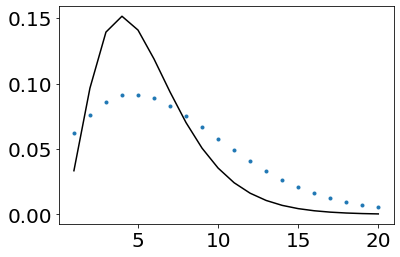

In [496]:
pi = sample_pi(4, model.lambda_scale, 7, model.nu_scale,samples=100000)

x = range(1,20+1)
pdf_vals = gamma.pdf(day_array, a=3.41,loc=0, scale =1/0.61)
plt.plot(x, pdf_vals,
       'k-', label='gamma prior');
plt.plot(x,model(day_array), '.', label='sampled poisson(lambda)/nu prior' )

In [323]:
def plot_gamma_prior(title, learned_values, alpha_param, beta_param):
    plt.figure(figsize=(15,8))
    x = np.linspace(0,1,1000)
    pdf_vals = beta.pdf(x, alpha_param, beta_param)
    plt.plot(x, pdf_vals,
           'k-', lw=5, label='beta prior');
    plt.plot([learned_values[0], learned_values[0]], [0, beta.pdf(learned_values[0],alpha_param, beta_param)],
             label=f'{title} non-vax',
            linestyle='--', linewidth=5)
    plt.plot([learned_values[1], learned_values[1]], [0, beta.pdf(learned_values[1],alpha_param, beta_param)],
             label=f'{title} vax',
            linestyle='--', linewidth=5)
    plt.legend()
    plt.title(title)


plot_beta_prior('Rho M', model.rho_M, alpha_bar_M, beta_bar_M)
plot_beta_prior('Rho X', model.rho_X, alpha_bar_X, beta_bar_X)
plot_beta_prior('Rho G', model.rho_G, alpha_bar_G, beta_bar_G)


NameError: name 'plot_beta_prior' is not defined

In [ ]:
learning_rate